# Test 1 & 2: Cholesky CPU

These test capture the runtime for the Cholesky decomposition with GPRat on the CPU.
We use a fixed problem size of $32768=2^{15}$, an increasing number of tiles in $\{1,2,4,8,16,32,64,128,256,512\}$, an increasing number of cores in $\{6,12,24,48\}$, 8 regressors and loop 10 times.
Note that we do not account for the time it takes to return the data to the callee.

Findings:

- There is no optimal number of cores. Therefore, we will use 48 cores for the other tests.
- ...

In [1]:
# setup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib as mpl
from scipy.stats.distributions import chi2
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes

mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams.update({'font.size': 9})
mpl.rcParams.update({'errorbar.capsize': 5})
mpl.rcParams.update({'grid.linewidth': 0.5})

In [2]:
# load data

apex_dir_cholesky = "./data/1"
apex_dir_steps = "./data/2"

names_cholesky = [
    "cholesky"
]

names_steps = [
    "cholesky_step assembly",
    "cholesky_step cholesky",
    "assemble K_tiles",
    "cholesky potrf",
    "cholesky trsm",
    "cholesky syrk",
    "cholesky gemm",
]

file_headers = [
    "n_cores",
    "n_train",
    "n_tiles",
    "n_reg",
    "n_loops"
]

def apex_files_to_df(dir, names):
    data = []
    for filename in os.listdir(dir):
        if filename.endswith(".csv"):
            parts = filename.replace("apex_profiles_", "").replace(".csv", "").split("_")
            file_params = dict(zip(file_headers, map(int, parts)))
            file_path = os.path.join(dir, filename)
            df = pd.read_csv(file_path)
            df = df[df['name'].isin(names)]
            for key, value in file_params.items():
                df[key] = value
            data.append(df)
    df_combined = pd.concat(data, ignore_index=True)
    df_combined = df_combined.sort_values(by='n_tiles')
    return df_combined

df_cholesky = apex_files_to_df(apex_dir_cholesky, names_cholesky)
df_steps = apex_files_to_df(apex_dir_steps, names_steps)

In [3]:
def confidence_error(df, confidence=0.95, column="stddev"):
    alpha = 1.0 - confidence
    lower_limit = df[column] * np.sqrt(
        (df["n_loops"] - 1) / chi2.ppf(1 - (alpha / 2), df=(df["n_loops"] - 1))
    )
    upper_limit = df[column] * np.sqrt(
        (df["n_loops"] - 1) / chi2.ppf(alpha / 2, df=(df["n_loops"] - 1))
    )
    return [lower_limit, upper_limit]

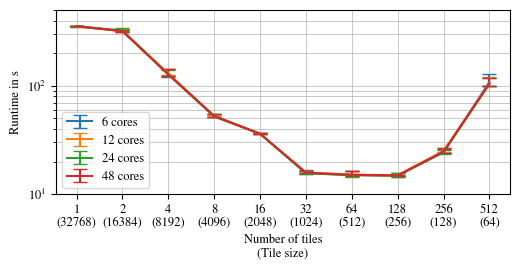

In [4]:
# plot for cholesky

n_train = 32768

plt.figure(figsize=(5, 2.5))

plt.xlabel('Number of tiles\n(Tile size)')
plt.ylabel('Runtime in s')
plt.grid(True, which="both")
plt.xscale('log', base=2)
plt.yscale("log", base=10)
plt.ylim(10,500)

xticks = df_cholesky['n_tiles'].unique()
tile_sizes = n_train / xticks
plt.xticks(
    xticks,
    [f"{int(tile)}\n({int(size)})" for tile, size in zip(xticks, tile_sizes)],
)

for n_cores, group in df_cholesky.groupby("n_cores"):
    lower, upper = confidence_error(group, 0.95)
    plt.errorbar(group['n_tiles'], group['mean']/10**9, yerr=[lower/10**9, upper/10**9], label=f"{n_cores} cores")

plt.legend()
plt.tight_layout(pad=0)
plt.savefig("./pdf/cholesky-cpu.pdf")

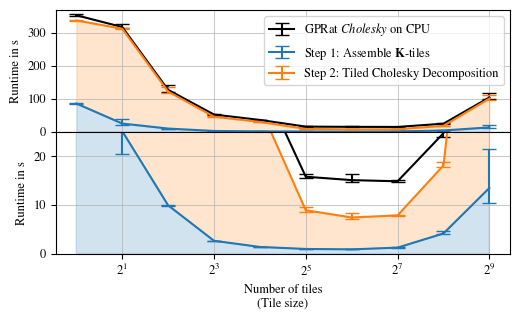

In [ ]:
# plot for cholesky steps

n_train = 32768
n_cores = 48

fig, ax = plt.subplots(2, 1, figsize=(5, 3), sharex=True, gridspec_kw={'hspace': 0})

ax[1].set_xlabel("Number of tiles\n(Tile size)")
ax[0].set_ylabel("Runtime in s")
ax[1].set_ylabel("Runtime in s")
ax[0].set_ylim(0, 370)
ax[1].set_ylim(0, 25)

xticks = df_steps["n_tiles"].unique()
tile_sizes = n_train / xticks
ax[1].set_xticks(
    xticks,
    [f"{int(tile)}\n({int(size)})" for tile, size in zip(xticks, tile_sizes)],
)

def plot(ax):
    xticks = df_cholesky["n_tiles"].unique()
    tile_sizes = n_train / xticks
    ax.grid(True, which="both")
    ax.set_xscale("log", base=2)
    df_cholesky_48 = df_cholesky[df_cholesky["n_cores"] == n_cores]
    lower, upper = confidence_error(df_cholesky_48, 0.95)
    ax.errorbar(
        df_cholesky_48["n_tiles"],
        df_cholesky_48["mean"] / 10**9,
        yerr=[lower / 10**9, upper / 10**9],
        color="black",
        label=r"GPRat $\mathit{Cholesky}$ on CPU",
    )

    names = [
        "cholesky_step assembly",
        "cholesky_step cholesky",
    ]

    colors = [
        "tab:blue",
        "tab:orange",
    ]
    legend = [
        r"Step 1: Assemble $\mathbf{K}$-tiles",
        f"Step 2: Tiled Cholesky Decomposition",
    ]

    df_accum = pd.DataFrame({
        'n_tiles': df_steps['n_tiles'].unique(),
        'mean': 0
    })
    df_prior = df_accum.copy()
    for name, label, color in zip(names, legend, colors):
        df_name = df_steps[df_steps["name"] == name]
        df_accum["mean"] += df_name["mean"].values
        lower, upper = confidence_error(df_name, 0.95)
        ax.errorbar(
            df_name["n_tiles"],
            df_accum["mean"] / 10**9,
            yerr=[lower / 10**9, upper / 10**9],
            color=color,
            label=label
        )
        ax.fill_between(
            df_name["n_tiles"],
            df_prior["mean"] / 10**9,
            df_accum["mean"] / 10**9,
            color=color,
            alpha=0.2,
        )
        df_prior = df_accum.copy()

plot(ax[0])
plot(ax[1])

ax[0].legend()
fig.tight_layout(pad=0)
fig.savefig("./pdf/cholesky-cpu-steps.pdf")

/home/moellh/dev/GPRat.git/plot/venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_146555/2520261409.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_name["acc_stddev"] = np.sqrt(df_name["stddev"]**2 * df_name["num samples/calls"] / df_name["n_loops"])


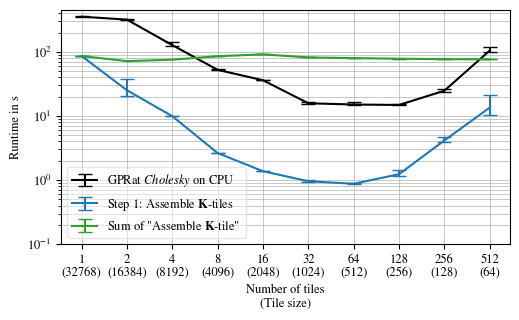

In [13]:
# plot for cholesky: Assembly

n_train = 32768
n_cores = 48

plt.figure(figsize=(5, 3))

plt.xlabel("Number of tiles\n(Tile size)")
plt.ylabel("Runtime in s")
plt.grid(True, which="both")
plt.xscale("log", base=2)
plt.yscale("log", base=10)
plt.ylim(0.1, 450)

xticks = df_cholesky["n_tiles"].unique()
tile_sizes = n_train / xticks
plt.xticks(
    xticks,
    [f"{int(tile)}\n({int(size)})" for tile, size in zip(xticks, tile_sizes)],
)

df_cholesky_48 = df_cholesky[df_cholesky["n_cores"] == n_cores]
lower, upper = confidence_error(df_cholesky_48, 0.95)
plt.errorbar(
    df_cholesky_48["n_tiles"],
    df_cholesky_48["mean"] / 10**9,
    yerr=[lower / 10**9, upper / 10**9],
    color="black",
    label=r"GPRat $\it{Cholesky}$ on CPU",
)

df_step_assembly = df_steps[df_steps["name"] == "cholesky_step assembly"]
lower, upper = confidence_error(df_step_assembly, 0.95)
plt.errorbar(
    df_step_assembly["n_tiles"],
    df_step_assembly["mean"] / 10**9,
    yerr=[lower / 10**9, upper / 10**9],
    label=r"Step 1: Assemble $\mathbf{K}$-tiles",
)


names_blas = [
    "assemble K_tiles",
]
names_steps_legend = [
    "Assemble tiles",
]

for i, (name, legend_name) in enumerate(zip(names_blas, names_steps_legend)):
    df_name = df_steps[df_steps["name"] == name]
    df_name["acc_stddev"] = np.sqrt(df_name["stddev"]**2 * df_name["num samples/calls"] / df_name["n_loops"])
    lower, upper = confidence_error(df_name, 0.95, "acc_stddev")
    plt.errorbar(
        df_name["n_tiles"],
        df_name["mean"] / 10**9 * df_name["num samples/calls"] / 10,
        yerr=[lower / 10**9, upper / 10**9],
        label=r'Sum of "Assemble $\mathbf{K}$-tile"',
        color="tab:green",
    )

plt.legend(framealpha=0.5)
plt.tight_layout(pad=0)
plt.savefig("./pdf/cholesky-cpu-assembly.pdf")

/home/moellh/dev/GPRat.git/plot/venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_146555/1644035731.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_name["acc_stddev"] = np.sqrt(df_name["stddev"]**2 * df_name["num samples/calls"] / df_name["n_loops"])
/home/moellh/dev/GPRat.git/plot/venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_146555/1644035731.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

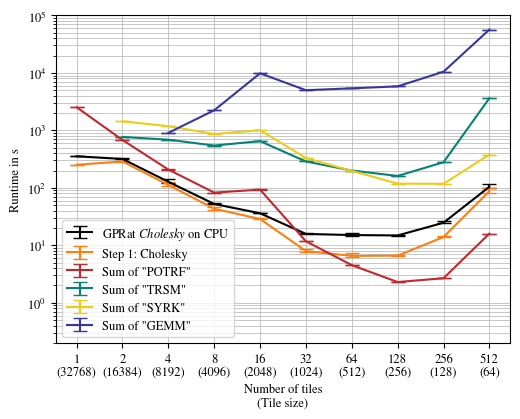

In [9]:
# plot for cholesky BLAS

n_train = 32768
n_cores = 48

plt.figure(figsize=(5, 4))

plt.xlabel("Number of tiles\n(Tile size)")
plt.ylabel("Runtime in s")
plt.grid(True, which="both")
plt.xscale("log", base=2)
plt.yscale("log", base=10)
# plt.ylim(0, 370)

xticks = df_cholesky["n_tiles"].unique()
tile_sizes = n_train / xticks
plt.xticks(
    xticks,
    [f"{int(tile)}\n({int(size)})" for tile, size in zip(xticks, tile_sizes)],
)

df_cholesky_48 = df_cholesky[df_cholesky["n_cores"] == n_cores]
lower, upper = confidence_error(df_cholesky_48, 0.95)
plt.errorbar(
    df_cholesky_48["n_tiles"],
    df_cholesky_48["mean"] / 10**9,
    yerr=[lower / 10**9, upper / 10**9],
    color="black",
    label=r"GPRat $\it{Cholesky}$ on CPU",
)

names_steps = [
    "cholesky_step cholesky",
]
names_steps_legend = [
    "Cholesky",
]

for i, (name, legend_name) in enumerate(zip(names_steps, names_steps_legend)):
    lower, upper = confidence_error(df_steps[df_steps["name"] == name], 0.95)
    plt.errorbar(
        df_steps[df_steps["name"] == name]["n_tiles"],
        df_steps[df_steps["name"] == name]["mean"] / 10**9,
        yerr=[lower / 10**9, upper / 10**9],
        label=f"Step {i+1}: {legend_name}",
        color="tab:orange",
    )

names_blas = [
    "cholesky potrf",
    "cholesky trsm",
    "cholesky syrk",
    "cholesky gemm",
]
names_steps_legend = [
    'Sum of "POTRF"',
    'Sum of "TRSM"',
    'Sum of "SYRK"',
    'Sum of "GEMM"',
]
colors = [
    "#c1282e",
    "#068176",
    "#edcc18",
    "#38369c",
]

for name, legend_name, color in zip(names_blas, names_steps_legend, colors):
    df_name = df_steps[df_steps["name"] == name]
    df_name["acc_stddev"] = np.sqrt(df_name["stddev"]**2 * df_name["num samples/calls"] / df_name["n_loops"])
    lower, upper = confidence_error(df_name, 0.95)
    plt.errorbar(
        df_steps[df_steps["name"] == name]["n_tiles"],
        df_steps[df_steps["name"] == name]["mean"]
        / 10**9
        * df_steps[df_steps["name"] == name]["num samples/calls"],
        yerr=[lower / 10**9, upper / 10**9],
        label=f"{legend_name}",
        color=color,
    )

plt.legend()
plt.tight_layout(pad=0)
plt.savefig("./pdf/cholesky-cpu-blas.pdf")